In [1]:
import numpy as np
import matplotlib.pyplot as plt

import json

%matplotlib inline

In [2]:
with open("temp/tests-1666381736.json", "r") as f:
    real = json.load(f)

In [3]:
def plot(datas, labels, title, filename, save_file=True):
    for v in datas:
        plt.title(title)
        T = np.array(range(len(v))) / 60
        plt.plot(T, v)
        plt.grid()
        plt.xlabel("Time(s)")
        plt.ylabel("Distance(cm)")
    plt.legend(labels)
    if save_file:
        plt.savefig(filename, format="jpeg")
    plt.show()

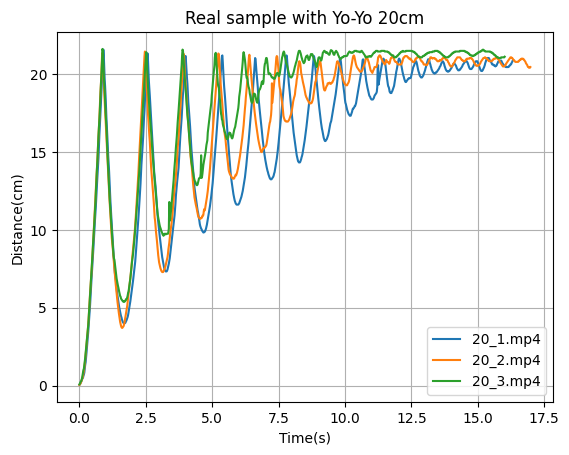

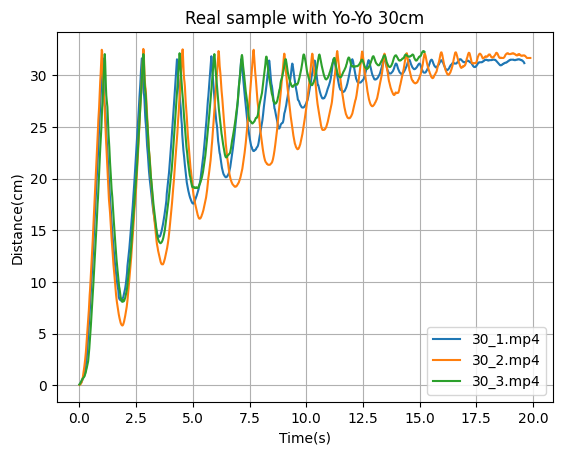

In [4]:
VIDEO_NAMES = [
    "20_1.mp4",
    "20_2.mp4",
    "20_3.mp4",
    "30_1.mp4",
    "30_2.mp4",
    "30_3.mp4"
]

plot(real[:3], VIDEO_NAMES[:3], "Real sample with Yo-Yo 20cm", "out/20cm.jpg", False)
plot(real[3:], VIDEO_NAMES[3:], "Real sample with Yo-Yo 30cm", "out/30cm.jpg", False)

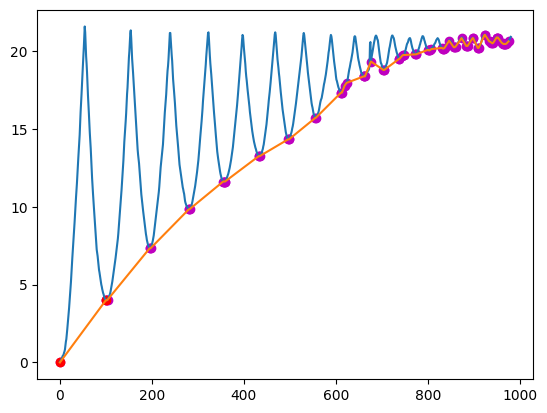

[  4.00195265   2.00043398   1.           1.           1.
   1.           1.           2.00043398   2.00043398   8.00694143
   1.           1.           1.           7.00793201   2.00043398
   2.00043398   2.00043398   2.00043398   1.           9.0096399
   1.          13.02668202   1.           1.          10.01951221
   1.          11.01135777   1.           1.           1.
  10.0124922   13.01127983   2.00043398   1.           1.
  10.00867679  10.01049796   2.00043398   1.           1.
   2.00043398  23.00015097   2.00043398   2.00043398   1.
   2.00043398  26.0016359    1.           1.          24.00003617
   1.           1.           2.00043398   6.00361581   1.
  32.00783867   1.           1.          27.00543284  13.03527532
   1.           1.           1.          37.00234602   4.00347072
   6.01748032   1.           1.          55.02400045   1.
  57.01658202   1.           1.          62.00946388   1.
   1.          73.01808423   1.           1.           1.
   1.          72

In [67]:
x_d = real[0]
points = [[0,0]]
for i in range(1, len(x_d) - 1):
    if x_d[i - 1] >= x_d[i] <= x_d[i + 1]:
        points.append([i, x_d[i]])

points = np.array(points).T
plt.plot(x_d)
plt.scatter(*points, c="m")
plt.scatter(*points[:, :2], c="r")
plt.plot(*points)
plt.show()

distance = []
dt = points[1, :-1] - points[1, 1:]
dt = np.power(dt, 2)
dx = points[0, :-1] - points[0, 1:]
dx = np.power(dx, 2)
s = np.sqrt(dt + dx)[::-1]
print(s)

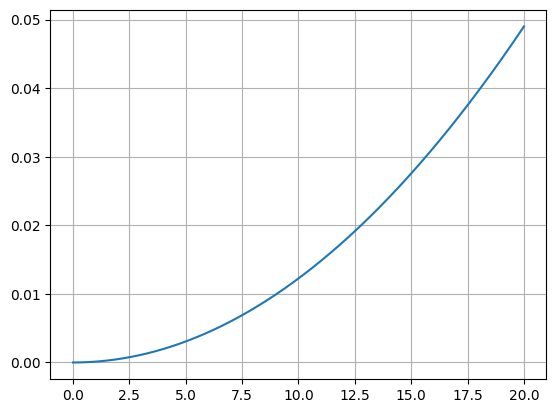

In [20]:
m=1
g=9.8
l=0.2
v=0
x=0
step=0.00001
direction=1

xx = []

tt = np.linspace(0, 20, 10000)

for t in tt:
    if (x>=l):
        v = -abs(v)+g*t + v * 0.1
    else:
        v = v + g*step
    x+=v*step
    xx.append(x)

plt.plot(tt, xx)
plt.grid()
plt.show()